## Importing required libraries

In [1]:
import sys
sys.path.append('/home/aistudio/external-libraries')

import jax
import jax.numpy as jnp
import jax.random as random

import time
import math
import numpy as np
import pandas as pd

import optax
import jaxopt
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from typing import Tuple

import process_log

import scipy.io
from scipy.stats import qmc
from scipy.special import factorial
jax.config.update("jax_enable_x64", True)

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Config for solving DDE

In [2]:
config = {
    "real_lag": 0.5,
    "real_a": 0.6,
    "real_b": 0.006,
    "noise_level": 0.0,
    "tmin": 0.,
    "tmax": 20.,
    "conds": [0., 1.],
    "initial_key": 0,
    "netLayers": [1, 10, 20, 10, 1],
    "record_info": True,
    "N_f": 5000,
    "step_epochs": [10000, 3000],
    "initial_lr" : 1e-3,
    "cosine_decay_steps": 1000,
    "cosine_alpha": 0.01,
    "given_data_root_path": "/home/aistudio/DDE_2rd_revision/data/ex4.2.2",
    "result_save_path": "/home/aistudio/DDE_2rd_revision/result/ex4.2.2"
}

In [3]:
# Retrieve the variable 'config' from IPython's storage space
# %store -r config

## Defining the Delay Differential Equation

Consider the delay differential equation with a single unknown time delay on the solution interval $[0,20]$:

\begin{equation}
\begin{cases}
\begin{aligned}
        y'(t) = {}& a \cdot y(t) - b \cdot y(t) \cdot y(t-\tau),,\qquad & t \geq 0\\
        y(t) = {}& 1, & t \leq 0
\end{aligned}
\end{cases}.
\end{equation}

In [4]:
# Define the differential equation
def DDE(t, u, lag, a, b):
    # Define u'(t)
    u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)))(t)

    # Define the right-hand side of the DDE
    rhs = a*u(t) - b*u(t)*jnp.where(t>lag, u(t-lag), 1)
    return u_t(t) - rhs

## Construct the DNNs and initialize parameters

In [5]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[:-2]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)

    w, b = params[-2]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    xavier_stddev = jnp.sqrt(2.0 / (m + n))

    w_key, b_key = jax.random.split(key)

    weights = xavier_stddev * jax.random.truncated_normal(
        w_key, lower=-2.0, upper=2.0, shape=(m, n)
    )
    biases = jnp.zeros((n,))

    return weights, biases

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Define the loss function

In [6]:
@jax.jit
def loss_fun1(params, inPoints, conds, init_data):
    lag, a, b = params[-1][0], params[-1][1], params[-1][2]
    t_c = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Compute the loss from the differential equation
    loss_f = jnp.mean(DDE(t_c, ufunc, lag, a, b)**2)

    # Compute the loss from the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_init = jnp.mean((ufunc(t_0) - u_0)**2)

    # Compute the loss from the gaven data
    t_g, u_g = init_data[:,0].reshape(-1,1), init_data[:,1].reshape(-1,1)
    loss_g = jnp.mean((u_g - ufunc(t_g))**2)

    # Compute the sum of loss from all components
    loss_sum = loss_f + loss_g + loss_init

    # Gather all loss terms
    all_losses = jnp.array([loss_f, loss_g, loss_init])
    total_loss = jnp.sum(all_losses)

    # Dynamic weights
    weights = all_losses / total_loss

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * weights)

    return loss_weighted, all_losses


@jax.jit
def loss_fun2(params, inPoints, conds, init_data, initial_weights):
    lag, a, b = params[-1][0], params[-1][1], params[-1][2]
    t_c = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Compute the loss from the differential equation
    loss_f = jnp.mean(DDE(t_c, ufunc, lag, a, b)**2)

    # Compute the loss from the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_init = jnp.mean((ufunc(t_0) - u_0)**2)

    # Compute the loss from the gaven data
    t_g, u_g = init_data[:,0].reshape(-1,1), init_data[:,1].reshape(-1,1)
    loss_g = jnp.mean((u_g - ufunc(t_g))**2)

    # Gather all loss terms
    all_losses = jnp.array([loss_f, loss_g, loss_init])

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * initial_weights)

    return loss_weighted, all_losses

## Two-step neural network training

In [7]:
# First Step：Adam Optimizer
def train_adam(params, inPoints, conds, init_data, record_info, num_epochs, start_epoch=0, log_interval=100, print_interval=1000):
    phase_epochs = []
    phase_losses = []
    phase_loss_terms = []
    phase_lag = []

    scheduler = optax.cosine_decay_schedule(
        init_value=config['initial_lr'],
        decay_steps=config['cosine_decay_steps'],
        alpha=config['cosine_alpha']
    )
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def update_adam(params, inPoints, conds, init_data, opt_state):
        (loss, all_losses), grads = jax.value_and_grad(loss_fun1, has_aux=True)(
            params, inPoints, conds, init_data
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (loss, all_losses)

    if record_info:
        for epoch in range(num_epochs):
            params, opt_state, (loss, all_losses) = update_adam(
                params, inPoints, conds, init_data, opt_state
            )
            current_epoch = start_epoch + epoch

            if record_info and current_epoch % log_interval == 0:
                phase_epochs.append(current_epoch)
                phase_losses.append(loss)
                phase_loss_terms.append(all_losses)
                phase_lag.append(params[-1])

            if record_info and current_epoch % print_interval == 0:
                print(f"Epoch {current_epoch}, Total Loss: {loss:.3e}")
        
        return params, phase_epochs, phase_losses, phase_loss_terms, phase_lag, all_losses
    else:
        now_epoch = 0
        while now_epoch < num_epochs:
            params, opt_state, (loss, all_losses) = update_adam(
                params, inPoints, conds, init_data, opt_state
            )
            now_epoch += 1
        return params, None, None, None, None, all_losses


# Second Step：BFGS Optimizer
def train_lbfgs(params, inPoints, conds, init_data, initial_weights,
                record_info, num_epochs=10000):
    current_params = params

    solver = jaxopt.My_BFGS(
        fun=loss_fun2,
        tol=1e-16,
        maxiter=num_epochs,
        has_aux=True,
        verbose=record_info
    )

    sol = solver.run(current_params, inPoints, conds, init_data, initial_weights)
    current_params = sol.params
    return current_params, sol.state.aux

def get_fixed_weights(loss_jnp):
    losses = jax.lax.stop_gradient(loss_jnp)
    return losses / jnp.sum(losses)

## Boundary Condition Initialization and Random Sampling Strategy for Solving DDE

In [8]:
lag = config["real_lag"]
a = config["real_a"]
b = config["real_b"]

# conds represents the initial condition y(0) = 1
conds = jnp.array(config['conds']).reshape(1,-1)

# Initial key for random number generator
ik = config['initial_key']

# Number of internal random points
N_f = config['N_f']

# Range for sampling points
tmin, tmax = config['tmin'], config['tmax']

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)

sampler = qmc.LatinHypercube(d=1)

sample = sampler.random(n=N_f)
Inn_T = qmc.scale(sample, tmin, tmax)
inPoints = jnp.array(Inn_T)

# Load the dataset with the given real lag value
given_data_path = os.path.join(config['given_data_root_path'], f"DDE23_ex4.2.2_tau_{lag}.csv")
given_data = pd.read_csv(given_data_path)

t_g_data = jnp.array(given_data.iloc[:, [0]].to_numpy())
y_g_data = jnp.array(given_data.iloc[:, [1]].to_numpy())

noise = config["noise_level"] * jax.random.normal(jaxKey, shape=t_g_data.shape)
y_g_noise_data = y_g_data*(1+noise)

# Extract given data points from the dataset and convert to JAX-compatible numpy array
init_data = jnp.column_stack((t_g_data, y_g_noise_data))

# Network architecture
netLayers = config['netLayers']

# Initialize network parameters
params = init_network_params(netLayers, jaxKey)

# Append the parameter for the inverse problem (time delay 'lag' and system parameters 'a' and 'b') to the network parameters
lag_and_system_params = jnp.array([0., 0., 0.], dtype=jnp.float64)
params.append(lag_and_system_params)

## Training

In [9]:
%%capture captured_output

adam_epochs = config["step_epochs"][0]
lbfgs_epochs = config["step_epochs"][1]
stage1_epochs = adam_epochs + lbfgs_epochs

record_info = config['record_info']

start_time_nn = time.time()

# 第一阶段adam训练
params, hist1_epoch, hist1_loss, hist1_loss_items, hist1_lag, loss_components = train_adam(params, inPoints, conds, init_data, record_info, adam_epochs, start_epoch=0, log_interval=10, print_interval=1000)

initial_weights = get_fixed_weights(loss_components)

# 第二阶段lbfgs训练
params, _ = train_lbfgs(params, inPoints, conds, init_data, initial_weights, record_info, num_epochs=lbfgs_epochs)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn


In [10]:
adam_arr = process_log.format_adam_log(hist1_epoch, hist1_loss, hist1_lag)
bfgs_arr, col_names = process_log.extract_bfgs_log_info(captured_output.stdout, adam_epochs, 5)
all_arr = np.vstack([adam_arr, bfgs_arr])

epoch_history = all_arr[:, 0]
loss_history = all_arr[:, 1]
lag_history = all_arr[:, 2:]

未提取到任何数据！请检查日志格式。


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5 and the array at index 1 has size 1

## Result visualization

In [ ]:
# save path
result_save_root_path = os.path.join(config['result_save_path'],f"tau_{config['real_lag']}")
os.makedirs(result_save_root_path, exist_ok=True)

### Sol

NameError: name 'result_save_root_path' is not defined

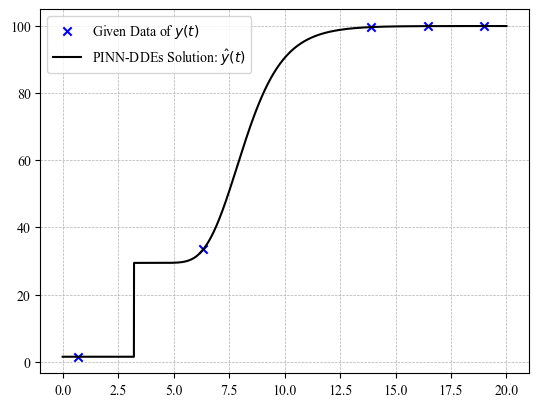

In [12]:
# Generate a linearly spaced array of time points
T = np.linspace(tmin, tmax, 10000).reshape(-1,1) 

# Evaluate the neural network at these time points
nn_sol1 = DNNs(params, T)

# Extract time points and real data from the dataset
t_points = given_data.iloc[:, 0]
y_real = given_data.iloc[:, 1]

# Set the figure size in centimeters (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the given data as scatter points
plt.scatter(t_points, y_real, label='Given Data of $y(t)$', color='blue', marker='x')

# Plot the neural network's predictions as a line
plt.plot(T, nn_sol1, 'k', label='PINN-DDEs Solution: $\hat{y}(t)$')

# Add a legend with custom font properties
plt.legend(prop=prop)

# Set the labels for the axes with custom font properties
# plt.xlabel('$t$', fontproperties=prop)
# plt.ylabel('$y(t)$', fontproperties=prop)

# Get the current axes, set the font properties for ticks
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add grid lines major only, with specific style and linewidth
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Sol_ex4.2.2_netLayers_{config['netLayers']}_tau_{config['real_lag']}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### Loss

In [ ]:
# Set up the figure with a specific size (converted from cm to inches)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the loss history over epochs
plt.plot(epoch_history[:-50], loss_history[:-50], 'k', label='Loss')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add a legend with a specific font
plt.legend(prop=prop, loc='upper right')

# Add axis labels with the specified font
# plt.xlabel('Epoch', fontproperties=prop)
# plt.ylabel('Loss', fontproperties=prop)

# Get the current axis for further customizationa
ax = plt.gca()

# Set font properties for tick labels on both axes
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add a grid to the plot with dashed lines for major ticks on both axes
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Export the plot to a file with a DPI of 600 and tight bounding box
save_path = os.path.join(result_save_root_path, f"Loss_ex4.2.2_tau_{lag}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### Lag

In [ ]:
# Define a function to compute relative error bounds
def relative_error_lines(real_value, error_percentage):
    """ Calculate the lower and upper bounds of real_value considering a percentage error. """
    lower_bound = real_value * (1 - error_percentage / 100)
    upper_bound = real_value * (1 + error_percentage / 100)
    return lower_bound, upper_bound, error_percentage

# Calculate error bounds for the given real_lag with a 3% error margin
lower_bound, upper_bound, error_percentage = relative_error_lines(config['real_lag'], 3)

# Set the figure size in a 4:3 aspect ratio
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the smoothed loss history
plt.plot(lag_history[:,0], loss_history, 'k', label='Loss')

# Draw vertical lines representing the 3% error range
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

# Set the y-axis to logarithmic scale for better visualization of differences
plt.yscale('log')

# Add labels to the axes
# plt.xlabel('$\\tau$', fontproperties=prop)
# plt.ylabel('Loss', fontproperties=prop)

# Customize the tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add grid lines, major only, with specific style
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Display the legend with custom font properties
plt.legend(prop=prop)

# axins = inset_axes(
#     ax,
#     width=1.5, height=1.5,
#     bbox_to_anchor=(300, 80), 
#     loc='lower left',
#     borderpad=0
# )

axins = inset_axes(
    ax,
    width=1.5, height=1.5,
    loc='lower left',
    bbox_to_anchor=(0.5, 0.1), 
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.plot(lag_history[:, 0], loss_history, 'k')
axins.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1)
axins.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

axins.set_xlim(lag - 0.05, lag + 0.05)
axins.set_ylim(1e-7, 1e-3)
axins.set_yscale('log')
axins.grid(True, linestyle='--', linewidth=0.4)
axins.tick_params(labelleft=False, labelbottom=False)

# Save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Lag_ex4.2.2_netLayers_{config['netLayers']}_tau_{config['real_lag']}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

### a

In [ ]:
# Define a function to compute relative error bounds
def relative_error_lines(real_value, error_percentage):
    """ Calculate the lower and upper bounds of real_value considering a percentage error. """
    lower_bound = real_value * (1 - error_percentage / 100)
    upper_bound = real_value * (1 + error_percentage / 100)
    return lower_bound, upper_bound, error_percentage

# Calculate error bounds for the given real_lag with a 3% error margin
lower_bound, upper_bound, error_percentage = relative_error_lines(config['real_a'], 3)

# Set the figure size in a 4:3 aspect ratio
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the smoothed loss history
plt.plot(lag_history[:, 1], loss_history, 'k', label='Loss')

# Draw vertical lines representing the 3% error range
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

# Set the y-axis to logarithmic scale for better visualization of differences
plt.yscale('log')

# Add labels to the axes
# plt.xlabel('$a$', fontproperties=prop)
# plt.ylabel('Loss', fontproperties=prop)

# Customize the tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add grid lines, major only, with specific style
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Display the legend with custom font properties
plt.legend(prop=prop,loc='lower left')

axins = inset_axes(
    ax,
    width=1.5, height=1.5,
    loc='lower left',
    bbox_to_anchor=(0.5, 0.1), 
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.plot(lag_history[:, 1], loss_history, 'k')
axins.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1)
axins.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

axins.set_xlim(a - 0.05, a + 0.05)
axins.set_ylim(1e-7, 1e-3)
axins.set_yscale('log')
axins.grid(True, linestyle='--', linewidth=0.4)
axins.tick_params(labelleft=False, labelbottom=False)

# Save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"a_ex2.2_netLayers_{config['netLayers']}_tau_{config['real_lag']}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### b

In [ ]:
# Define a function to compute relative error bounds
def relative_error_lines(real_value, error_percentage):
    """ Calculate the lower and upper bounds of real_value considering a percentage error. """
    lower_bound = real_value * (1 - error_percentage / 100)
    upper_bound = real_value * (1 + error_percentage / 100)
    return lower_bound, upper_bound, error_percentage

# Calculate error bounds for the given real_lag with a 3% error margin
lower_bound, upper_bound, error_percentage = relative_error_lines(config['real_b'], 3)

# Set the figure size in a 4:3 aspect ratio
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the smoothed loss history
plt.plot(lag_history[:, 2], loss_history, 'k', label='Loss')

# Draw vertical lines representing the 3% error range
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

# Set the y-axis to logarithmic scale for better visualization of differences
plt.yscale('log')

# Add labels to the axes
# plt.xlabel('$b$', fontproperties=prop)
# plt.ylabel('Loss', fontproperties=prop)

# Customize the tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add grid lines, major only, with specific style
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Display the legend with custom font properties
plt.legend(prop=prop,loc='lower left')

axins = inset_axes(
    ax,
    width=1.5, height=1.5,
    loc='lower left',
    bbox_to_anchor=(0.5, 0.1), 
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.plot(lag_history[:, 2], loss_history, 'k')
axins.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1)
axins.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

axins.set_xlim(b - 0.0005, b + 0.0005)
axins.set_ylim(1e-7, 1e-3)
axins.set_yscale('log')
axins.grid(True, linestyle='--', linewidth=0.4)
axins.tick_params(labelleft=False, labelbottom=False)

# Save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"b_ex2.2_netLayers_{config['netLayers']}_tau_{config['real_lag']}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

## Calculating Error

In [ ]:
# Calculate the absolute and relative errors for lag, a, and b
absolute_error_lag = abs(params[-1][0] - config['real_lag'])
relative_error_lag = absolute_error_lag / config['real_lag']

absolute_error_a = abs(params[-1][1] - config['real_a'])
relative_error_a = absolute_error_a / config['real_a']

absolute_error_b = abs(params[-1][2] - config['real_b'])
relative_error_b = absolute_error_b / config['real_b']

# Print the calculated values for verification
print(f"Absolute Error (lag): {absolute_error_lag}")
print(f"Relative Error (lag): {relative_error_lag}")
print(f"Absolute Error (a): {absolute_error_a}")
print(f"Relative Error (a): {relative_error_a}")
print(f"Absolute Error (b): {absolute_error_b}")
print(f"Relative Error (b): {relative_error_b}")

# Save the results to a text file for documentation purposes
output_file = os.path.join(result_save_root_path, f"Result_ex4.2.2_netLayers_{config['netLayers']}_tau_{config['real_lag']}.txt")
with open(output_file, "w") as file:
    file.write(f"Real Lag: {config['real_lag']}\n")
    file.write(f"netLayers: {config['netLayers']}\n")
    file.write(f"Absolute Error (lag): {absolute_error_lag}\n")
    file.write(f"Relative Error (lag): {relative_error_lag}\n")
    file.write(f"Absolute Error (a): {absolute_error_a}\n")
    file.write(f"Relative Error (a): {relative_error_a}\n")
    file.write(f"Absolute Error (b): {absolute_error_b}\n")
    file.write(f"Relative Error (b): {relative_error_b}\n")

# Uncomment the line below to confirm that the results have been successfully saved
# print(f"Results have been saved to {output_file}")
